In [1]:
%load_ext autoreload
%autoreload 2
import pickle
import numpy as np
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
import IPython.display as ipd
import pyximport
pyximport.install()
%load_ext Cython
import sigkernel as ksig
from utils.data import *
from model.generators import *

# Setup

In [2]:
hist_len = 10
sample_len = 30 #NOTE it includes the hist_len
noise_dim = 4
seq_dim = 3 # (gap, duration, pitch)
scale = 1.
stride = 800
# max_pitch = 32
# pitch_offset = 37
key = 'single_key'

sigma = 1.0
kernel_type = 'truncated'
dyadic_order = 3
n_levels = 5
order = 5

batch_size = 64
activation = 'Tanh'
hidden_size = 64
n_layers = 1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
with open(f'./data/dataframes/{key}/dfs.pkl', 'rb') as f:
    dfs = pickle.load(f)
len(dfs)

802

In [5]:
lens = [len(df) for df in dfs]
print('Max length:', max(lens))
stride = max(lens) + 1 # ensures no sampling from middle of song

Max length: 384


Min pitch: 38
Max pitch: 98


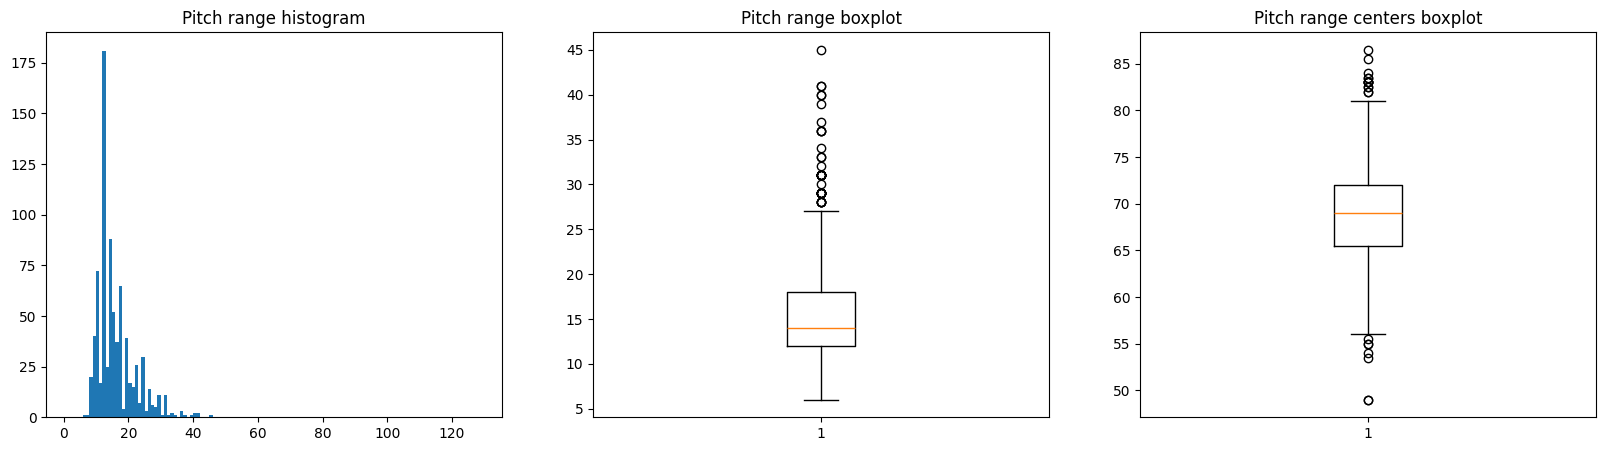

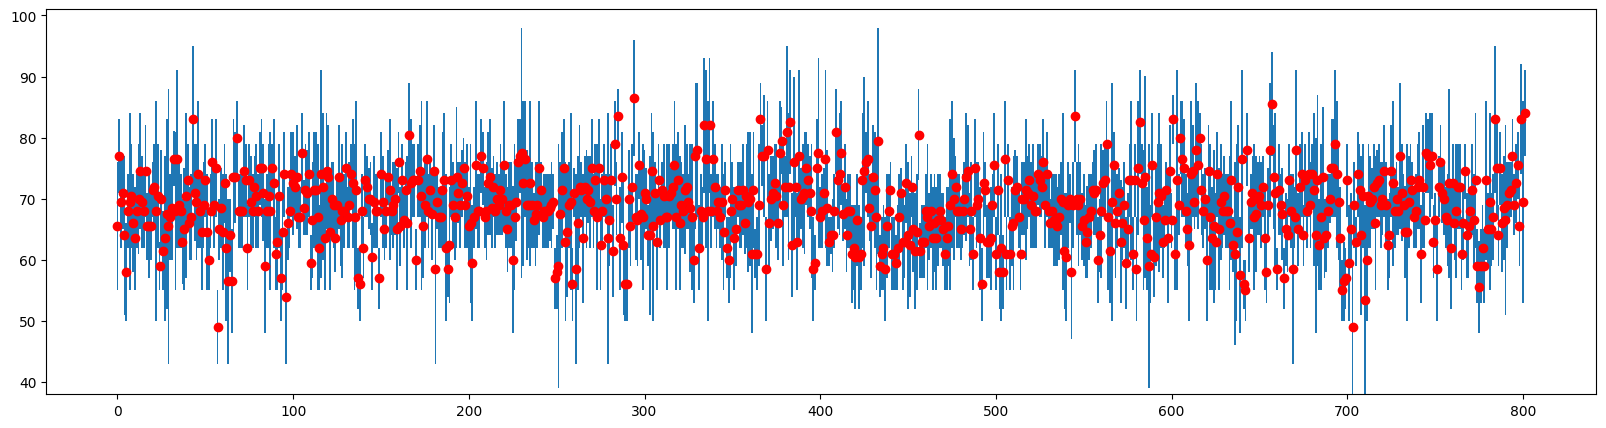

(38, 98)

In [5]:
pitch_range(dfs)

In [6]:
gap_dur_dpitch_dfs = gap_duration_deltapitch_transform(dfs)
dataset = GapDurationDeltaPitchDataset(gap_dur_dpitch_dfs, sample_len=sample_len, scale=scale, stride=stride)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
len(dataset), len(dataloader)

(802, 13)

In [7]:
generator = LSTMinc(noise_dim, seq_dim, sample_len, hidden_size, n_layers, activation)
generator = generator.cuda()
optimizer = torch.optim.Adam(generator.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5, verbose=True)

In [8]:
if kernel_type == 'truncated':
    static_kernel = ksig.static.kernels.RationalQuadraticKernel(sigma=sigma)
    kernel = ksig.kernels.SignatureKernel(n_levels=n_levels, order=order, normalization=0, static_kernel=static_kernel, device_ids=None)
elif kernel_type == 'pde':
    static_kernel = ksig.sigkernelpde.RationalQuadraticKernel(sigma=sigma, alpha=1.0)
    kernel = ksig.sigkernelpde.SigKernelPDE(static_kernel, dyadic_order)

# Training

In [9]:
for epoch in range(100):
    losses = []
    for batch_num, X in enumerate(tqdm(dataloader)):
        X = X.to(device)
        X_rect = batch_rectilinear_with_gap_transform(X[:, hist_len:, :])

        # int_noise = torch.randint(0, 12, (X.shape[0], 1)).to(device)
        # int_noise = int_noise.float().repeat(1, X.shape[1]-1).unsqueeze(-1)
        # gaussian_noise = torch.randn(X.shape[0], X.shape[1]-1, noise_dim-1).to(device)
        # noise = torch.cat([int_noise, gaussian_noise], dim=-1)
        noise = torch.randn(X.shape[0], X.shape[1]-1, noise_dim).to(device)
        Y = generator(noise, X[:, :hist_len, :], X[:, hist_len:, :2])

        Y_rect = batch_rectilinear_with_gap_transform(Y[:, hist_len:, :])
        # print(output.shape, X.shape, X[:, :hist_len, :].shape)

        # compute loss
        optimizer.zero_grad()
        loss = ksig.tests.mmd_loss_no_compile(X_rect, Y_rect, kernel)
        losses.append(loss.item())

        # backpropagate and update weights
        loss.backward()
        optimizer.step()

    # log epoch loss and plot generated samples
    epoch_loss = np.average(losses) # average batch mmd for epoch
    scheduler.step(epoch_loss)
    print(f'Epoch {epoch+1}, loss: {epoch_loss}')

  0%|          | 0/13 [00:00<?, ?it/s]

100%|██████████| 13/13 [00:19<00:00,  1.47s/it]


Epoch 1, loss: 5.494918676523062


100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Epoch 2, loss: 0.7427646563603327


100%|██████████| 13/13 [00:18<00:00,  1.46s/it]


Epoch 3, loss: 0.28635127727801984


100%|██████████| 13/13 [00:18<00:00,  1.45s/it]


Epoch 4, loss: 0.2563914519089919


100%|██████████| 13/13 [00:19<00:00,  1.47s/it]


Epoch 5, loss: 0.256650814643273


100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Epoch 6, loss: 0.24197736153235802


100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Epoch 7, loss: 0.2345108068906344


100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Epoch 8, loss: 0.23200427568875825


100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Epoch 9, loss: 0.20136246314415565


100%|██████████| 13/13 [00:18<00:00,  1.46s/it]


Epoch 10, loss: 0.2116081164433406


100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Epoch 11, loss: 0.17221894631019005


100%|██████████| 13/13 [00:18<00:00,  1.45s/it]


Epoch 12, loss: 0.19398076717670149


100%|██████████| 13/13 [00:18<00:00,  1.45s/it]


Epoch 13, loss: 0.20592759205744818


100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Epoch 14, loss: 0.20354289274949294


100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Epoch 15, loss: 0.19773211845984826


100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Epoch 16, loss: 0.185015843464778


100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Epoch 00017: reducing learning rate of group 0 to 5.0000e-04.
Epoch 17, loss: 0.19539730365459734


100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Epoch 18, loss: 0.1761622979090764


100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Epoch 19, loss: 0.1798259294950045


100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Epoch 20, loss: 0.16262872402484602


100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Epoch 21, loss: 0.17830470892099234


100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Epoch 22, loss: 0.19479531508225661


100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Epoch 23, loss: 0.1750498918386606


100%|██████████| 13/13 [00:19<00:00,  1.48s/it]


Epoch 24, loss: 0.16976099747877854


100%|██████████| 13/13 [00:19<00:00,  1.49s/it]


Epoch 25, loss: 0.16675718014056867


100%|██████████| 13/13 [00:19<00:00,  1.48s/it]


Epoch 26, loss: 0.150820071880634


100%|██████████| 13/13 [00:19<00:00,  1.49s/it]


Epoch 27, loss: 0.15132777507488543


100%|██████████| 13/13 [00:19<00:00,  1.50s/it]


Epoch 28, loss: 0.19289820010845476


100%|██████████| 13/13 [00:19<00:00,  1.50s/it]


Epoch 29, loss: 0.2091825191791241


100%|██████████| 13/13 [00:19<00:00,  1.49s/it]


Epoch 30, loss: 0.18728923797607422


100%|██████████| 13/13 [00:19<00:00,  1.48s/it]


Epoch 31, loss: 0.17113465529221755


100%|██████████| 13/13 [00:19<00:00,  1.49s/it]


Epoch 32, loss: 0.14990571828988883


100%|██████████| 13/13 [00:19<00:00,  1.48s/it]


Epoch 33, loss: 0.1564974051255446


100%|██████████| 13/13 [00:19<00:00,  1.49s/it]


Epoch 34, loss: 0.1572261773622953


100%|██████████| 13/13 [00:19<00:00,  1.49s/it]


Epoch 35, loss: 0.14674938642061675


100%|██████████| 13/13 [00:18<00:00,  1.45s/it]


Epoch 36, loss: 0.16058202890249398


100%|██████████| 13/13 [00:18<00:00,  1.45s/it]


Epoch 37, loss: 0.14229260958158052


100%|██████████| 13/13 [00:19<00:00,  1.46s/it]


Epoch 38, loss: 0.1318018253032978


100%|██████████| 13/13 [00:18<00:00,  1.45s/it]


Epoch 39, loss: 0.16075280996469352


100%|██████████| 13/13 [00:19<00:00,  1.48s/it]


Epoch 40, loss: 0.14758594219501203


100%|██████████| 13/13 [00:19<00:00,  1.52s/it]


Epoch 41, loss: 0.12499504822951096


100%|██████████| 13/13 [00:19<00:00,  1.53s/it]


Epoch 42, loss: 0.14416812016413763


100%|██████████| 13/13 [00:19<00:00,  1.50s/it]


Epoch 43, loss: 0.14092425199655387


100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Epoch 44, loss: 0.16146116990309495


100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Epoch 45, loss: 0.14249882331261268


100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Epoch 46, loss: 0.15316383655254656


100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Epoch 00047: reducing learning rate of group 0 to 2.5000e-04.
Epoch 47, loss: 0.17557279880230242


100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Epoch 48, loss: 0.15352113430316633


100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Epoch 49, loss: 0.12368011474609375


100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Epoch 50, loss: 0.17114896040696365


100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Epoch 51, loss: 0.12113031974205604


100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Epoch 52, loss: 0.15936066554142878


100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Epoch 53, loss: 0.1354043300335224


100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Epoch 54, loss: 0.1307379282437838


100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Epoch 55, loss: 0.11408380361703727


100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Epoch 56, loss: 0.1474455686715933


100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Epoch 57, loss: 0.15349589861356294


100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Epoch 58, loss: 0.15081952168391302


100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Epoch 59, loss: 0.1304757411663349


100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Epoch 60, loss: 0.10902305749746469


100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Epoch 61, loss: 0.18862295150756836


100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Epoch 62, loss: 0.12881880540114182


100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Epoch 63, loss: 0.13840480951162484


100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Epoch 64, loss: 0.1651164935185359


100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Epoch 65, loss: 0.11396939937884991


100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Epoch 00066: reducing learning rate of group 0 to 1.2500e-04.
Epoch 66, loss: 0.1638938830449031


100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Epoch 67, loss: 0.14809557107778695


100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Epoch 68, loss: 0.11587986579308143


100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Epoch 69, loss: 0.15040115209726188


100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Epoch 70, loss: 0.13157954582801232


100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Epoch 71, loss: 0.13459975902850813


100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Epoch 00072: reducing learning rate of group 0 to 6.2500e-05.
Epoch 72, loss: 0.14410176643958458


100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Epoch 73, loss: 0.14582003079927885


100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Epoch 74, loss: 0.10951654727642353


100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Epoch 75, loss: 0.12451802767240085


100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Epoch 76, loss: 0.13980340957641602


100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Epoch 77, loss: 0.1445616575387808


100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Epoch 00078: reducing learning rate of group 0 to 3.1250e-05.
Epoch 78, loss: 0.11984403316791241


100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Epoch 79, loss: 0.11345811990591195


100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Epoch 80, loss: 0.15650132986215445


100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Epoch 81, loss: 0.12267314470731296


100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Epoch 82, loss: 0.14427959001981294


100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Epoch 83, loss: 0.13407127673809344


100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Epoch 00084: reducing learning rate of group 0 to 1.5625e-05.
Epoch 84, loss: 0.159391109759991


100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Epoch 85, loss: 0.13084818766667292


100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Epoch 86, loss: 0.1529061244084285


100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Epoch 87, loss: 0.09890493979820839


100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Epoch 88, loss: 0.136137632223276


100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Epoch 89, loss: 0.1254093463604267


100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Epoch 90, loss: 0.12047701615553635


100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Epoch 91, loss: 0.14318315799419695


100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Epoch 92, loss: 0.13045296302208534


100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Epoch 00093: reducing learning rate of group 0 to 7.8125e-06.
Epoch 93, loss: 0.14376699007474458


100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Epoch 94, loss: 0.1388561909015362


100%|██████████| 13/13 [00:18<00:00,  1.46s/it]


Epoch 95, loss: 0.12178274301382211


100%|██████████| 13/13 [00:18<00:00,  1.46s/it]


Epoch 96, loss: 0.13252691122201773


100%|██████████| 13/13 [00:18<00:00,  1.45s/it]


Epoch 97, loss: 0.12153343053964469


100%|██████████| 13/13 [00:18<00:00,  1.45s/it]


Epoch 98, loss: 0.11608105439406174


100%|██████████| 13/13 [00:18<00:00,  1.45s/it]


Epoch 00099: reducing learning rate of group 0 to 3.9063e-06.
Epoch 99, loss: 0.17331801928006685


100%|██████████| 13/13 [00:18<00:00,  1.45s/it]

Epoch 100, loss: 0.11482770626361553


In [39]:
# torch.save(generator.state_dict(), f'./data/weights/gapdurdpitch_{noise_dim}z_{sample_len}l_{hist_len}h_{key}_{n_levels}m_{order}o_{hidden_size}u_{n_layers}lstm.pt')

# Evaluation

In [9]:
generator.load_state_dict(torch.load(f'./data/weights/gapdurdpitch_{noise_dim}z_{sample_len}l_{hist_len}h_{key}_{n_levels}m_{order}o_{hidden_size}u_{n_layers}lstm.pt'))

<All keys matched successfully>

In [10]:
for X in dataloader:
    X = X.to(device)
    noise = torch.randn(X.shape[0], X.shape[1]-1, noise_dim).to(device)
    Y = generator(noise, X[:, :hist_len, :], X[:, hist_len:, :2])
    break

### Sample and play MIDI

In [11]:
start_pitch = 60
X_dfs = batch_gap_duration_pitch_to_df(X, start_pitch=start_pitch)
Y_dfs = batch_gap_duration_pitch_to_df(Y, start_pitch=start_pitch)

In [12]:
sample_idx = 1

In [13]:
X_dfs[1]

Start        End  Pitch  Velocity
0    0.000000   0.258621   60.0      80.0
1    0.258621   0.517241   59.0      80.0
2    0.517241   1.551724   55.0      80.0
3    2.068966   2.327587   60.0      80.0
4    2.327587   2.586207   59.0      80.0
5    2.586207   2.844828   60.0      80.0
6    2.844828   3.103449   59.0      80.0
7    3.103449   3.362070   55.0      80.0
8    3.362070   3.879311   57.0      80.0
9    3.879311   4.655173   50.0      80.0
10   6.724139   6.982760   62.0      80.0
11   6.982760   7.241381   59.0      80.0
12   7.241381   7.500001   62.0      80.0
13   7.500001   8.017242   64.0      80.0
14   8.017242   9.310347   62.0      80.0
15  10.344830  10.862071   64.0      80.0
16  10.862071  11.120691   64.0      80.0
17  11.120691  11.379313   62.0      80.0
18  11.379313  11.637933   59.0      80.0
19  11.637933  12.931037   62.0      80.0
20  14.482761  14.741383   60.0      80.0
21  14.741383  15.000003   59.0      80.0
22  15.000003  15.258623   60.0      80.0
23  15.258623  15.517244   59.0      80.0
24  15.517244  16.034485   55.0      80.0
25  16.034485  16.293106   57.0      80.0
26  16.293106  17.327589   50.0      80.0
27  18.362072  18.620693   62.0      80.0
28  18.620693  18.879314   62.0      80.0
29  18.879314  19.396555   62.0      80.0

In [14]:
input_midi = df_to_midi(X_dfs[sample_idx])
output_midi = df_to_midi(Y_dfs[sample_idx])

In [15]:
pd.merge(X_dfs[sample_idx][['Start', 'End', 'Pitch']], Y_dfs[sample_idx][['Pitch']], left_index=True, right_index=True)

Start        End  Pitch_x  Pitch_y
0    0.000000   0.258621     60.0     60.0
1    0.258621   0.517241     59.0     59.0
2    0.517241   1.551724     55.0     55.0
3    2.068966   2.327587     60.0     60.0
4    2.327587   2.586207     59.0     59.0
5    2.586207   2.844828     60.0     60.0
6    2.844828   3.103449     59.0     59.0
7    3.103449   3.362070     55.0     55.0
8    3.362070   3.879311     57.0     57.0
9    3.879311   4.655173     50.0     50.0
10   6.724139   6.982760     62.0     58.0
11   6.982760   7.241381     59.0     59.0
12   7.241381   7.500001     62.0     57.0
13   7.500001   8.017242     64.0     57.0
14   8.017242   9.310347     62.0     55.0
15  10.344830  10.862071     64.0     58.0
16  10.862071  11.120691     64.0     57.0
17  11.120691  11.379313     62.0     56.0
18  11.379313  11.637933     59.0     57.0
19  11.637933  12.931037     62.0     59.0
20  14.482761  14.741383     60.0     62.0
21  14.741383  15.000003     59.0     62.0
22  15.000003  15.258623     60.0     58.0
23  15.258623  15.517244     59.0     57.0
24  15.517244  16.034485     55.0     57.0
25  16.034485  16.293106     57.0     61.0
26  16.293106  17.327589     50.0     65.0
27  18.362072  18.620693     62.0     63.0
28  18.620693  18.879314     62.0     62.0
29  18.879314  19.396555     62.0     61.0

In [30]:
fs=44100
audio_data = input_midi.fluidsynth(fs=fs, sf2_path='./data/soundfonts/Steinway_Grand_Piano_1.2.sf2')
ipd.Audio(audio_data, rate=fs)

In [21]:
fs=44100
audio_data = output_midi.fluidsynth(fs=fs, sf2_path='./data/soundfonts/Steinway_Grand_Piano_1.2.sf2')
ipd.Audio(audio_data, rate=fs)

### Evaluate note within key percentages

In [22]:
key_to_note = {0: 'C', 1: 'C#', 2: 'D', 3: 'D#', 4: 'E', 5: 'F', 6: 'F#', 7: 'G', 8: 'G#', 9: 'A', 10: 'A#', 11: 'B'}
key_notes = []
for i in range(12):
    key_notes.append(get_notes_from_major_scale(i))

In [23]:
# check percentage of notes in C major scale
X_key_percentages = {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 10: [], 11: []}
Y_key_percentages = {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 10: [], 11: []}
for df in X_dfs:
    for i in range(len(key_notes)):
        percentage = len([note for note in df['Pitch'].values if note in key_notes[i]]) / len(df['Pitch'].values)
        X_key_percentages[i].append(percentage)
for df in Y_dfs:
    for i in range(len(key_notes)):
        percentage = len([note for note in df['Pitch'].values if note in key_notes[i]]) / len(df['Pitch'].values)
        Y_key_percentages[i].append(percentage)

Key: C
Mean percentage of notes in key C: 0.7145833333333333
Mean percentage of notes in key C#: 0.640625
Mean percentage of notes in key D: 0.38958333333333334
Mean percentage of notes in key D#: 0.8088541666666667
Mean percentage of notes in key E: 0.35572916666666665
Mean percentage of notes in key F: 0.7552083333333334
Mean percentage of notes in key F#: 0.4447916666666667
Mean percentage of notes in key G: 0.6156250000000001
Mean percentage of notes in key G#: 0.7505208333333333
Mean percentage of notes in key A: 0.33906250000000004
Mean percentage of notes in key A#: 0.8140625
Mean percentage of notes in key B: 0.3713541666666666


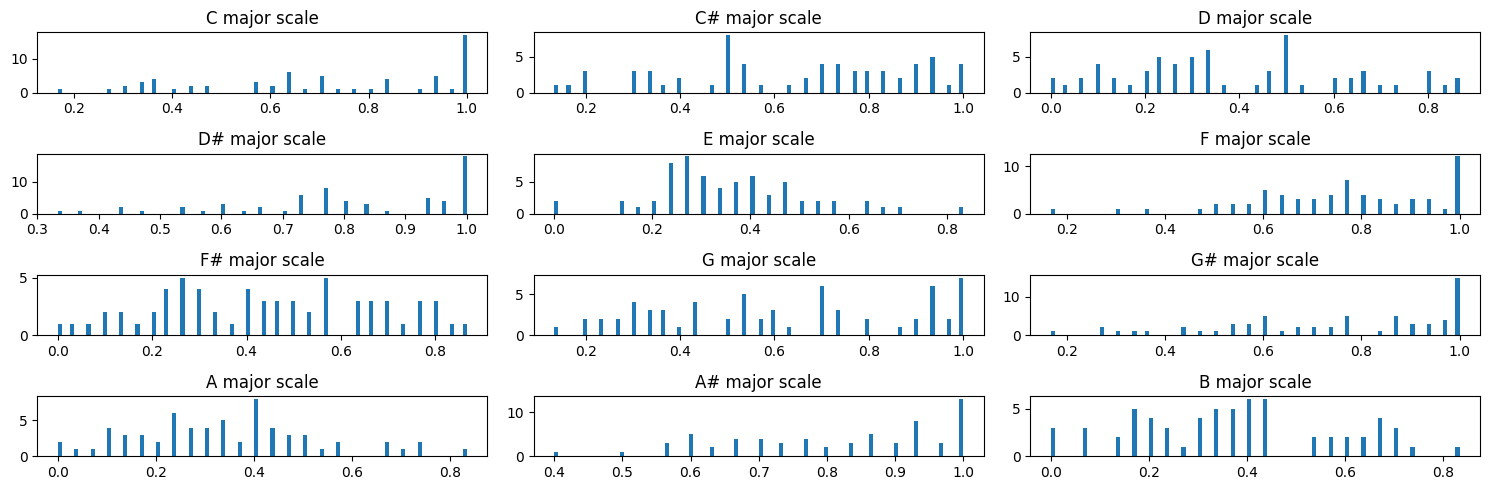

In [24]:
fig, ax = plt.subplots(4, 3, figsize=(15, 5))
print(f'Key: {key_to_note[start_pitch % 12]}')
for i in range(len(key_notes)):
    print(f'Mean percentage of notes in key {key_to_note[i]}: {np.mean(X_key_percentages[i])}')
    ax[i//3, i%3].hist(X_key_percentages[i], bins=100)
    ax[i//3, i%3].set_title(f'{key_to_note[i]} major scale')
plt.tight_layout()

Key: C
Mean percentage of notes in key C: 0.6260416666666666
Mean percentage of notes in key C#: 0.6109375
Mean percentage of notes in key D: 0.5057291666666667
Mean percentage of notes in key D#: 0.6624999999999999
Mean percentage of notes in key E: 0.49739583333333337
Mean percentage of notes in key F: 0.6447916666666667
Mean percentage of notes in key F#: 0.5296875
Mean percentage of notes in key G: 0.5973958333333333
Mean percentage of notes in key G#: 0.65
Mean percentage of notes in key A: 0.49166666666666664
Mean percentage of notes in key A#: 0.6692708333333333
Mean percentage of notes in key B: 0.5145833333333333


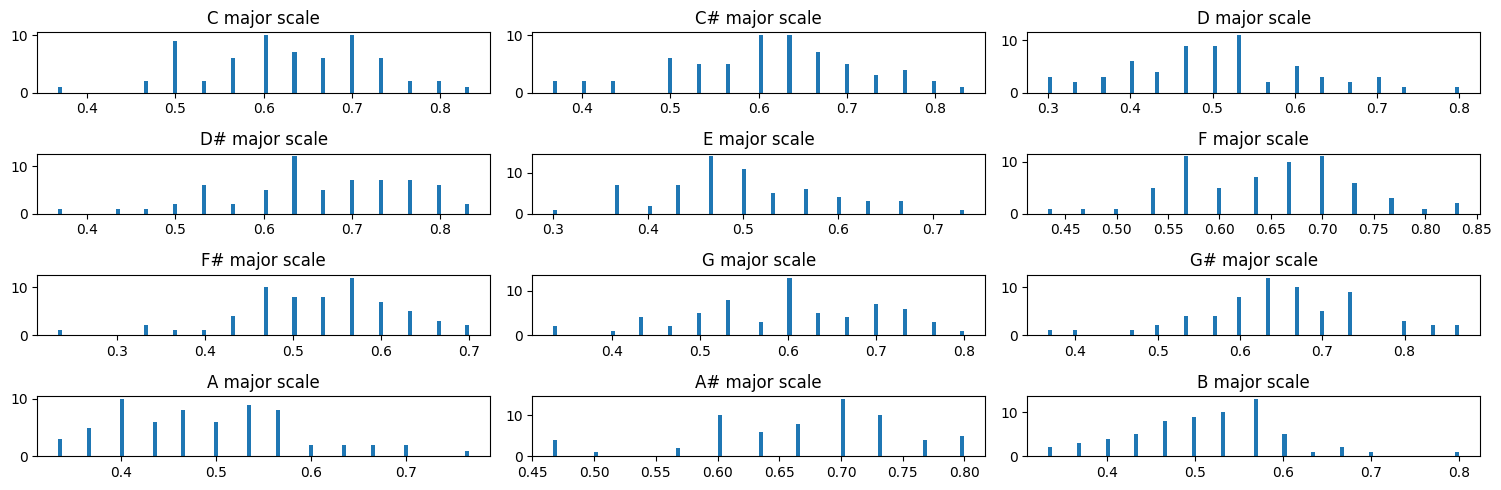

In [25]:
fig, ax = plt.subplots(4, 3, figsize=(15, 5))
print(f'Key: {key_to_note[start_pitch % 12]}')
for i in range(len(key_notes)):
    print(f'Mean percentage of notes in key {key_to_note[i]}: {np.mean(Y_key_percentages[i])}')
    ax[i//3, i%3].hist(Y_key_percentages[i], bins=100)
    ax[i//3, i%3].set_title(f'{key_to_note[i]} major scale')
plt.tight_layout()